In [3]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from torch import tensor
import numpy as np
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import random
import os
import matplotlib.pyplot as plt
#from numba import jit
import pickle
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader, random_split
import torch
from torchsummary import summary

torch.backends.cudnn.benchmark = True
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model

In [112]:
# Up samples to 256 from 128
class Single2D(nn.Module):
    def __init__(self):
        super(Single2D, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, padding=3)
        self.bn1 = nn.BatchNorm2d(128)
        
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(256)
        
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(512)
        
        self.conv4 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn5 = nn.BatchNorm2d(128)
        
        
        self.fc1 = nn.Linear(7680, 512)
        self.d1 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(512, 256)
        self.d2 = nn.Dropout(0.25)
        
        self.fc3 = nn.Linear(256, 64)
        self.d3 = nn.Dropout(0.25)
        
        self.fc4 = nn.Linear(64, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.unsqueeze(1)
        #x = x.reshape(batch_size, 1, 2, 128)
        print(x.shape)
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
       # x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d3(x)
        
        
        x = self.fc4(x)
        return x

In [105]:
# Up samples to 128 from 32
class DualDownUp(nn.Module):
    def __init__(self):
        super(DualDownUp, self).__init__()
        self.conv1 = nn.Conv1d(2, 32, kernel_size=5, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=5)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(128)
        
        """ self.conv4 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(128)"""
        
        self.conv4 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(64)
        
        self.conv5 = nn.Conv1d(64, 32, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn5 = nn.BatchNorm1d(32)
        
        self.fc1 = nn.Linear(96, 64)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(64, 32)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(32, 16)
        self.d3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(16, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        x = self.pool5(torch.relu(self.bn5(self.conv5(x))))
        
       # x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        
        #x = x.view(batch_size, -1)
        x = x.view(batch_size, -1)

        x = torch.relu(self.fc1(x))
        x = self.d1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d3(x)
        
        x = self.fc4(x)
        return x

In [30]:
# Up samples to 256 from 128
class DualUp(nn.Module):
    def __init__(self):
        super(DualUp, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.conv4 = nn.Conv1d(512, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(256)
        
        self.conv5 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn5 = nn.BatchNorm1d(128)
        
        
        self.fc1 = nn.Linear(7680, 512)
        self.d1 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(512, 256)
        self.d2 = nn.Dropout(0.25)
        
        self.fc3 = nn.Linear(256, 64)
        self.d3 = nn.Dropout(0.25)
        
        self.fc4 = nn.Linear(64, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
       # x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d3(x)
        
        
        x = self.fc4(x)
        return x

In [90]:
# Down samples from 128 features
class DualDown(nn.Module):
    def __init__(self):
        super(DualDown, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding='same')
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.conv3 = nn.Conv1d(64, 32, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(32)
        
        self.conv4 = nn.Conv1d(32, 16, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(16)
        
        self.fc1 = nn.Linear(112, 64)
        self.d1 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(64, 32)
        self.d2 = nn.Dropout(0.25)
        
        self.fc3 = nn.Linear(32, 16)
        self.d3 = nn.Dropout(0.25)
        
        self.fc4 = nn.Linear(16, 6)

    def forward(self, x):
        #x = x.type(torch.FloatTensor)
        #print(type(x))# Train/test functions
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d3(x)
        
        
        
        x = self.fc4(x)
        return x

# Train/test functions

In [10]:
def train(train_loader, net, LR=0.1, epochs=2000, val_loader=None):
    net.to(DEVICE)
    optimizer = optim.Adam(net.parameters(), lr=LR)
    criterion = nn.L1Loss()
    all_MSE = nn.L1Loss()
    val_losses = []
    print(f"Using: {DEVICE}")
                            
    parameter_loss = []
    losses = []
    processed = 0
    last_loss = 0
    for epoch in range(epochs):
        loss = 0
        
        net.train()
        with tqdm(train_loader, unit="batch") as it:
            if epoch > 0:
                it.set_postfix(lastLoss=last_loss, valLoss=val_losses[-1])
            for idx, data in enumerate(it):
                it.set_description(f"Epoch {epoch+1}/{epochs}")
                inp, out = data['input'].to(DEVICE), data['output'].to(DEVICE)
                
                optimizer.zero_grad()
                predicted = net(inp)

                cost = criterion(out, predicted)
                loss += cost.item()
                cost.backward()
                optimizer.step()
                
                for i in range(len(predicted)):
                    current_MSE = []
                    for j in range(6):
                        current_MSE.append(all_MSE(out[i][j], predicted[i][j]).item())
                    parameter_loss.append(current_MSE)
                    processed += 1
        
        if val_loader:
            val_loss = 0
            net.eval()
            for idx, data in enumerate(val_loader):
                inp, out = data['input'].to(DEVICE), data['output'].to(DEVICE)

                predicted = net(inp)
                cost = criterion(out, predicted)
                val_loss += cost.item()
            val_loss /= len(val_loader)  
            val_losses.append(val_loss)
        
        losses.append(loss)
        last_loss = loss/len(it)
    print("Parameters: Skin YM, Adipose YM, Skin PR, Adipose PR, Skin Perm, Adipose Perm")
    print(f"Sampled Ranges: 10e3 - 50e3, 1e3 - 25e3, 0.48 - 0.499, 0.48 - 0.499, 10e - 12-10e10, 10e-12 - 10e10") 
    print(f"Average parameter loss: {np.mean(np.reshape(np.array(parameter_loss), (-1, 6)), axis=0)}")        
    print(f"Average overall loss: {np.sum(losses)/processed}")
    return losses, parameter_loss, val_losses

def test(test_loader, net):
    net.to(DEVICE)
    net.eval()
    criterion = nn.L1Loss()
    crit = nn.L1Loss()
    differences = []
    

    with torch.no_grad():
            loss = 0
            with tqdm(test_loader, unit=" batch") as it:
                for idx, data in enumerate(it):
                    inp, out = data['input'].to(DEVICE), data['output'].to(DEVICE)
                    
                    predicted = net(inp)
                    cost = criterion(out, predicted)
                    l_t = cost.item()
                    loss += l_t
                    for i in range(len(predicted)):
                        p = predicted[i].cpu().numpy().reshape(1, -1)
                        o = out[i].cpu().numpy().reshape(1, -1)
                        
                        p = SCALER.inverse_transform(p)[0]
                        o = SCALER.inverse_transform(o)[0]

                        
                        differences.append(np.abs(p-o))
                        #print("D", differences[-1])
                        #print(F"Predicted: {SCALER.inverse_transform(p)}")
                        #print(F"Real: {SCALER.inverse_transform(o)}")
                        #print(f"Difference: {abs(p - o)}\n\n")
                        #processed += 1
                    
                    #print(f"\n\n\nBatch: {idx}")
                   # print(f"loss: {l_t}")
            print(differences[0])
            print(np.array(differences).shape)
            print(f"Average Loss: {loss/len(test_loader)}")
            print(f"Average parameter loss: {np.mean(np.array(differences), axis=0)}") # Dataset

# Dataset

In [11]:
with open("filtered.pkl", "rb") as f:
    runs = pickle.load(f)

In [12]:
from sklearn.preprocessing import MinMaxScaler
SCALER = MinMaxScaler()

In [13]:
# Folder name will correspond to index of sample

from sklearn.preprocessing import MinMaxScaler
SCALER = MinMaxScaler()
class Data(Dataset):
    def __init__(self, signalFolder, sampleFile, runs=range(65535), steps=128):
        # Load both disp1 and disp2 from each folder
        # Folders ordered according to index of sample
        # Use the corresponding sample as y -> append probe?
        self.input = []
        self.output = []
        
        with open(f"{sampleFile}", "rb") as f:
             samples = pickle.load(f)
        
        self.min = np.min(samples[runs])
        self.max = np.max(samples[runs])
        
        for run in tqdm(runs): #os.listdir(f"{signalFolder}/"):  
            inp = []
            fail = False
            
            files = os.listdir(f"{signalFolder}/{run}/")
            
            if files != ['Disp1.csv', 'Disp2.csv']:
                continue
            
            for file in files:
                a = pd.read_csv(f"{signalFolder}/{run}/{file}")
                a.rename(columns = {'0':'x', '0.1': 'y'}, inplace = True)
                
                if a['x'].max() != 7.0:
                    fail = True
                    break
                #a = pd.concat([pd.DataFrame([[0,0.1]], columns=a.columns), a], ignore_index=True)
                

                # Interpolate curve for consistent x values
                xNew = np.linspace(0, 7, num=steps, endpoint=False)
                interped = interp1d(a['x'], a['y'], kind='cubic', fill_value="extrapolate")(xNew)
                    
                #fix, ax = plt.subplots(1, 2)
                #ax[0].plot(xNew, interped)
                #a.plot(ax=ax[1], x='x', y='y')
                #if run == 3:
                   # break
                
                
                #if len(a) < 702:
                #    print(f"{signalFolder}/{run}/{file}: {len(a)}")
               #     fail = True
                 #   break
                
               # while len(a) > 702:
                #    a = a.drop(index=np.random.randint(0, len(a)-1)).reset_index(drop=True)
                
                #print(a)
                
                inp.append(interped.astype("float32"))
            
            if not fail:
                if len(inp) != 2:
                    raise Exception("sdf")
                #print(inp[0])
                #raise Exception("sdf")

                self.input.append(inp)
                self.output.append(samples[int(run)])
        
        SCALER.fit(self.output)
        self.output = SCALER.fit_transform(self.output)
        self.output = tensor(self.output).type(torch.cuda.FloatTensor)
        self.input = tensor(self.input).type(torch.cuda.FloatTensor)
        
    def __len__(self):
        return len(self.output)
    
    def __getitem__(self, idx):
        sample = {"input": self.input[idx], "output": self.output[idx]}
        return sample

In [14]:
dataset = Data("D:/SamplingResults", "C:/Users/rjsou/Documents/MastersDiss/Sampling/Samples.pkl", runs=runs)

100%|██████████████████████████████████████████████████████████████████████████████| 2241/2241 [00:39<00:00, 56.97it/s]
C:\Users\rjsou\AppData\Local\Temp\ipykernel_10924\3404371057.py:73: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  self.input = tensor(self.input).type(torch.cuda.FloatTensor)


## Train/test split

In [15]:
train_n = int(0.8 * len(dataset))
test_n = len(dataset) - train_n
train_set, test_set = random_split(dataset, [train_n, test_n])
train_loader, test_loader = DataLoader(train_set, batch_size=32, shuffle=True), DataLoader(test_set, batch_size=32, shuffle=True)

# Training/testing

In [35]:
upDown = DualDownUp() # Extracts 32, then takes to 128

In [115]:
upDownLoss, upDown_ploss, upDown_vloss = train(train_loader, upDown, val_loader=test_loader, LR=0.001, epochs=200)

Using: cuda:0


Epoch 68/200: 100%|███████████████████████████████████| 56/56 [00:02<00:00, 23.40batch/s, lastLoss=0.15, valLoss=0.187]


Epoch 136/200: 100%|██████████████████████████████████| 56/56 [00:02<00:00, 23.77batch/s, lastLoss=0.15, valLoss=0.176]


Epoch 200/200: 100%|█████████████████████████████████| 56/56 [00:02<00:00, 23.60batch/s, lastLoss=0.147, valLoss=0.173]


Parameters: Skin YM, Adipose YM, Skin PR, Adipose PR, Skin Perm, Adipose Perm
Sampled Ranges: 10e3 - 50e3, 1e3 - 25e3, 0.48 - 0.499, 0.48 - 0.499, 10e - 12-10e10, 10e-12 - 10e10
Average parameter loss: [0.1125583  0.19239459 0.1027091  0.19960648 0.16420398 0.15162257]
Average overall loss: 0.004856761695424425


In [116]:
up = DualUp() # Upsamples to 256 features

In [117]:
upLoss, up_ploss, up_vloss = train(train_loader, up, val_loader=test_loader, LR=0.001, epochs=200)

Using: cuda:0


Epoch 68/200: 100%|██████████████████████████████████| 56/56 [00:02<00:00, 25.04batch/s, lastLoss=0.121, valLoss=0.221]


Epoch 136/200: 100%|█████████████████████████████████| 56/56 [00:02<00:00, 25.02batch/s, lastLoss=0.116, valLoss=0.212]


Epoch 200/200: 100%|█████████████████████████████████| 56/56 [00:02<00:00, 24.62batch/s, lastLoss=0.114, valLoss=0.226]


Parameters: Skin YM, Adipose YM, Skin PR, Adipose PR, Skin Perm, Adipose Perm
Sampled Ranges: 10e3 - 50e3, 1e3 - 25e3, 0.48 - 0.499, 0.48 - 0.499, 10e - 12-10e10, 10e-12 - 10e10
Average parameter loss: [0.07901295 0.14920783 0.09899722 0.16231855 0.16218509 0.09092091]
Average overall loss: 0.003908133983670859


In [118]:
down = DualDown() # Downsamples from 128 to 32

In [119]:
downLoss, down_ploss, down_vloss = train(train_loader, down, val_loader=test_loader, LR=0.001, epochs=200)

Using: cuda:0


Epoch 68/200: 100%|█████████████████████████████████████| 56/56 [00:02<00:00, 24.40batch/s, lastLoss=0.13, valLoss=0.5]


Epoch 136/200: 100%|██████████████████████████████████| 56/56 [00:02<00:00, 24.48batch/s, lastLoss=0.125, valLoss=1.25]


Epoch 200/200: 100%|█████████████████████████████████| 56/56 [00:02<00:00, 24.31batch/s, lastLoss=0.125, valLoss=0.242]


Parameters: Skin YM, Adipose YM, Skin PR, Adipose PR, Skin Perm, Adipose Perm
Sampled Ranges: 10e3 - 50e3, 1e3 - 25e3, 0.48 - 0.499, 0.48 - 0.499, 10e - 12-10e10, 10e-12 - 10e10
Average parameter loss: [0.09226322 0.16169397 0.09983728 0.17424578 0.16269174 0.10591145]
Average overall loss: 0.0041911037435719434


In [113]:
single2d = Single2D()

In [114]:
single2dLoss, single2d_ploss, single2d_vloss = train(train_loader, single2d, val_loader=test_loader, LR=0.001, epochs=250)

Using: cuda:0


Epoch 1/250:   0%|                                                                           | 0/56 [00:00<?, ?batch/s]

torch.Size([32, 1, 2, 128])


RuntimeError: pad should be at most half of kernel size, but got pad=3 and kernel_size=2

# Results

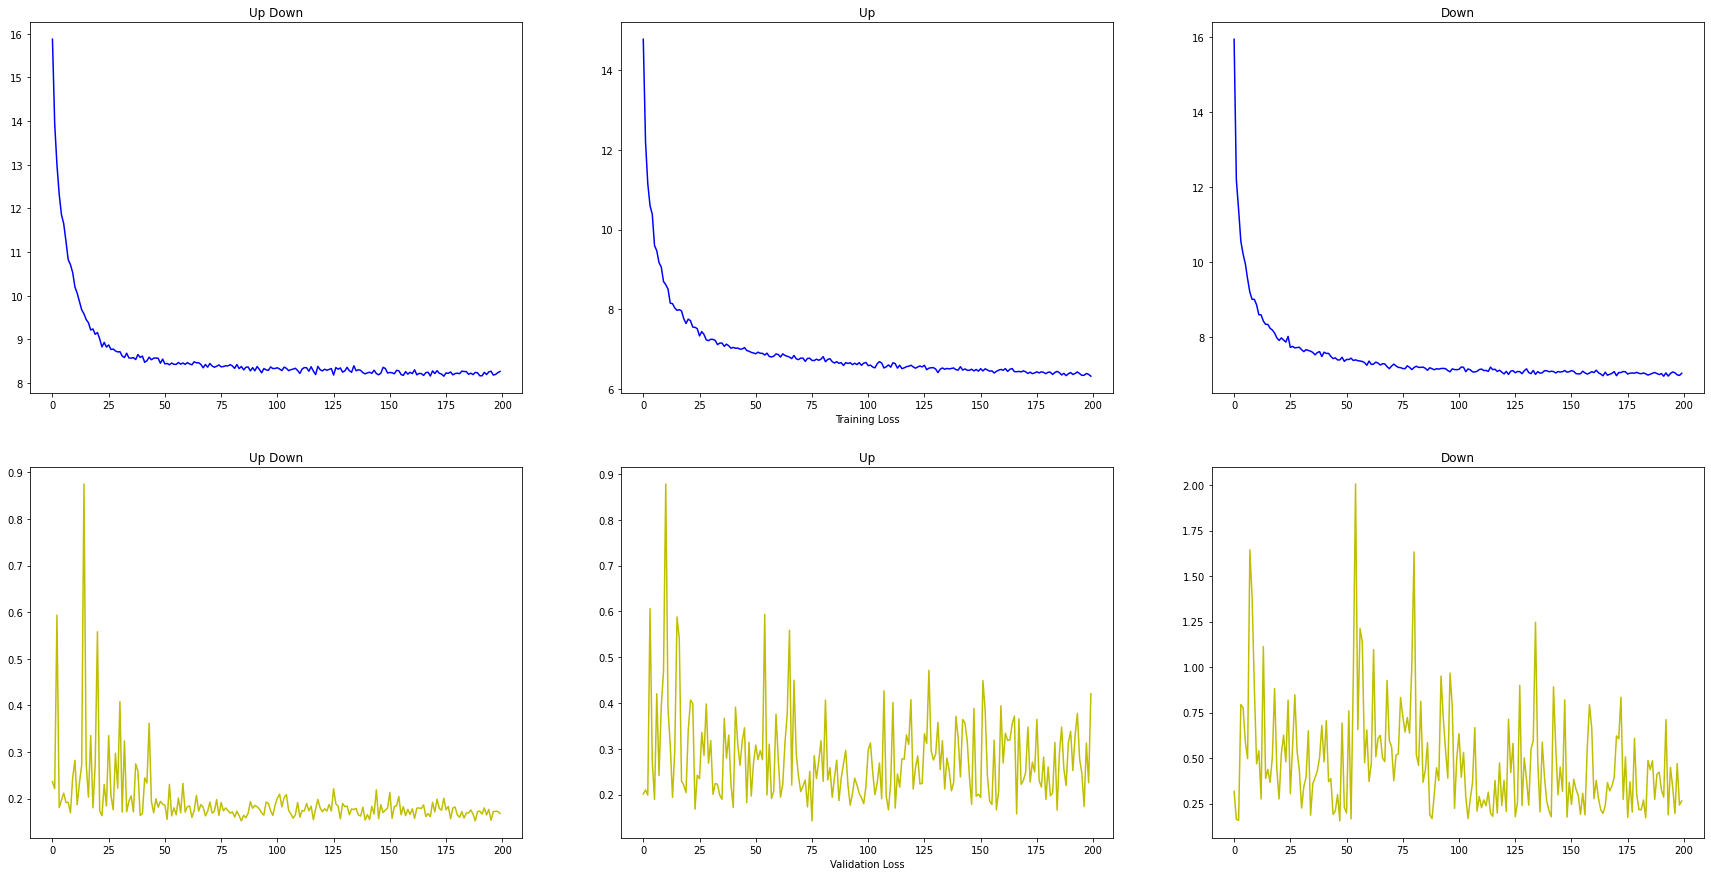

In [122]:
fig, ax = plt.subplots(2, 3, figsize=(30, 15))
x = range(0, 200)

ax[0][1].set_xlabel("Training Loss")
ax[1][1].set_xlabel("Validation Loss")

for i in range(2):
    ax[i][0].set_title("Up Down")
    ax[i][1].set_title("Up")
    ax[i][2].set_title("Down")


for i, res in enumerate([(upDownLoss, upDown_vloss), (upLoss, up_vloss), (downLoss, down_vloss)]):
    for j in range(2):
        ax[j][i].plot(x, res[j], c = "b" if j == 0 else "y")
    
plt.show()

In [118]:
print("Parameter Losses")
print("Up Down:", np.mean(upDown_ploss, axis=0))
print("Up:", np.mean(up_ploss, axis=0))
print("Down:", np.mean(down_ploss, axis=0))

print("\n\nMin train/val Losses")
print(f"Up Down, {min(upDownLoss)}/{min(upDown_vloss)}")
print(f"Up: {min(upLoss)}, /{min(up_vloss)}")
print(f"Down, {min(downLoss)}/{min(down_vloss)}")

Parameter Losses
Up Down: [0.11429728 0.19058375 0.10185253 0.19653361 0.16324614 0.1449314 ]
Up: [0.08923231 0.16268644 0.10074071 0.1745592  0.16228959 0.10841407]
Down: [0.07239292 0.13895136 0.09730897 0.15115594 0.1562405  0.07453726]


Min train/val Losses
Up Down, 8.068312034010887/0.1424594989844731
Up: 6.883540205657482, /0.1456210059779031
Down, 5.893041029572487/0.1577995249203273


In [116]:
len(up_p)

[5.364418029785156e-07,
 0.0757797509431839,
 0.060605406761169434,
 0.21840360760688782,
 0.15401411056518555,
 0.37659168243408203]